In [12]:
import os 
import ipyvolume as ipv
from tyssue import HistoryHdf5
from tyssue.draw import browse_history
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [124]:
filename = '0.5_polarity_[1157, 232, 509]_perturbation_1324094.302695705_ve_0'
history = HistoryHdf5.from_archive(
    '/home/admin-suz/Documents/Code/polarity/notebooks/20200305-variability/'+filename+'/'+filename+'.hf5'
    )

specs = {
    "face": {
        "visible": True,
        "color":lambda sheet :sheet.face_df.fold,
        #"color": lambda sheet : sheet.face_df['ablate'],
        "colormap": 'Blues',
        "alpha": 0.2
    },
    "edge": {
        "visible": True,
        "color":'black',
    },
    
}


browse_history(history, coords=['z', 'x', 'y'], **specs)
ipv.style.use("dark")
ipv.style.box_off()
ipv.pylab.style.axes_off()

interactive(children=(IntSlider(value=0, description='i', max=149), Output()), _dom_classes=('widget-interact'…

In [80]:
sheet = history.retrieve(30)




In [81]:
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers import QSSolver
import json
from polarity.toolbox import modify_some_initial_settings


from polarity.dynamics import EllipsoidLameGeometry as geom


import ipyvolume as ipv

from tyssue.draw import sheet_view


solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)

json_filename='superegg_final.json'
with open('../examples/' + json_filename, 'r+') as fp:
        specs = json.load(fp)

In [94]:
sheet=history.retrieve(50)
sheet.settings

{'geometry': 'spherical',
 'height_axis': 'z',
 'nrj_norm_factor': 784,
 'lumen_prefered_vol': 1655117.8783696312,
 'lumen_vol': 1268434.8363365438,
 'lumen_vol_elasticity': 2e-05,
 'threshold_length': 0.1,
 'lumen_volume_elasticity': 3e-06,
 'barrier_radius': 100}

In [82]:
from polarity.toolbox import define_polarity
sheet.update_specs(specs)
modify_some_initial_settings(sheet)
sheet.settings['barrier_radius'] = 100

sheet.edge_df['weight'] = sheet.edge_df['weighted']

define_polarity(sheet, 1., 0.4)
sheet.face_df['prefered_perimeter'] = 3.8 * np.sqrt(sheet.face_df['prefered_area'])
sheet.face_df['perimeter_elasticity'] = 100

sheet.edge_df['weight'] = sheet.edge_df.groupby('face').apply(
    lambda df: (df["num_sides"] * df["weight"] / df["weight"].sum())
).sort_index(level=1).to_numpy()


In [83]:
model = model_factory(
    [
        effectors.BarrierElasticity,
        effectors.RadialTension,
        effectors.PerimeterElasticity,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ])

res = solver.find_energy_min(sheet, geom, model)#, options={"ftol": 1e-8, "gtol": 1e-8})
print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [84]:

class Compress(effectors.AbstractEffector):
    
    dimensions = units.line_elasticity
    magnitude = 'compression'
    label = 'Compression'
    element = 'vert'
    specs = {
        'vert': {'compression': 1.0,}
    }
    
    @staticmethod
    def energy(eptm):
        return eptm.vert_df.eval(
            '0.5 * compression * z**2')

    @staticmethod
    def gradient(eptm):
        grad = pd.DataFrame(np.zeros((eptm.Nv, 3)), columns=['g' + c for c in eptm.coords])
        grad["gz"] =  eptm.vert_df.eval('compression * z')
        return grad, None
    

In [87]:
model = model_factory(
    [
        Compress,
        #effectors.BarrierElasticity,
        effectors.RadialTension,
        effectors.PerimeterElasticity,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ])



sheet.vert_df['compression'] = 5.0


In [90]:
#sheet.vert_df['compression'] = 2.6
res = solver.find_energy_min(sheet, geom, model, options={"ftol": 1e-8, "gtol": 1e-8})

ipv.clear()

fig, mesh = sheet_view(sheet, mode='3D', face={"visible": False}) 
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [89]:
print(res.message)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


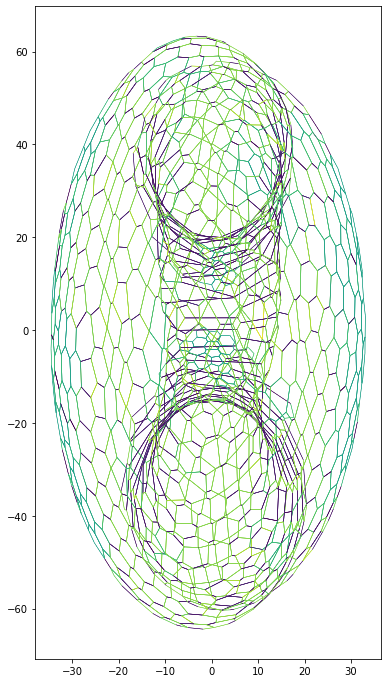

In [71]:


sheet_ = sheet.extract_bounding_box(x_boundary=[0, 120])



fig, mesh = sheet_view(
    sheet_,
    mode='2D',
    coords=['z', 'y'],
    **{
        "face":{"visible": False}, 
        "edge":{"visible":True,
                "color": sheet_.edge_df.weight,
                }
    }
) 
fig.set_size_inches(12, 12)


In [44]:
np.arctan2(0, 0)

0.0

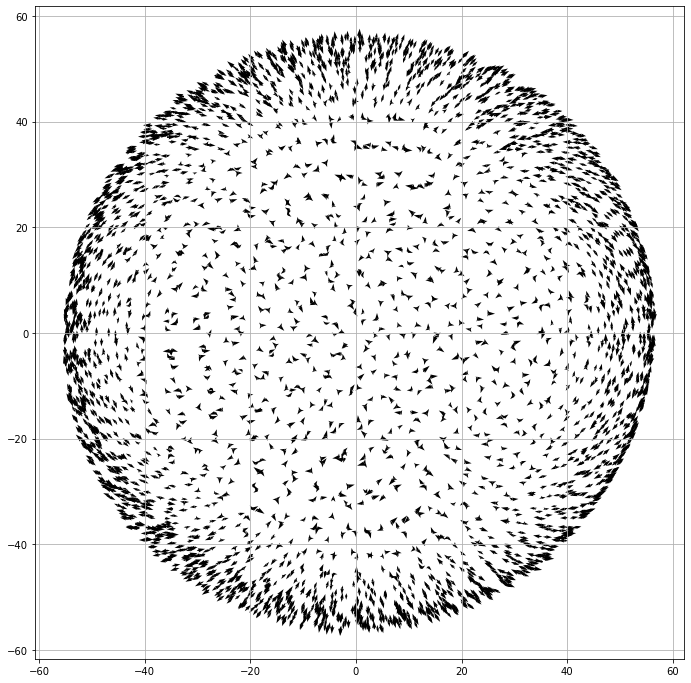

In [37]:
fig, ax = plt.subplots()

ax.quiver(sheet.edge_df.sx, sheet.edge_df.sy, sheet.edge_df.dx_r, sheet.edge_df.dy_r, units="xy")
ax.set_aspect('equal')
ax.grid()
fig.set_size_inches(12, 12)

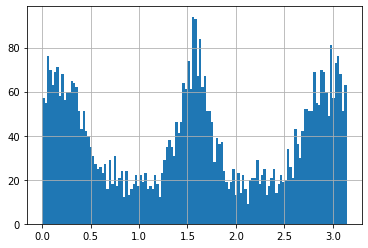

In [18]:
_ = (sheet_.edge_df.phi).hist(bins=128)

In [105]:
l, h = sheet.edge_df.groupby('weight').count().iloc[:, 0]
print(l/h)


0.1860886366380872


In [13]:
def update_latrad(sheet):
    radius_ = sheet.vert_df.eval("(x**2+y**2)**0.5")
    sheet.vert_df['depth'] = radius_.max() - radius_
    sheet.vert_df['latitude'] = np.arctan2(sheet.vert_df.y, sheet.vert_df.x)

In [14]:
from scipy.signal import find_peaks
from scipy.optimize import brentq
from scipy.interpolate import splev, splrep

def get_slice(sheet, l0=0, largeur=0.3):
    """ l0 should be between -π and π
    
    """
    vert = sheet.vert_df[
        (sheet.vert_df.latitude<l0+largeur/2)
        & (sheet.vert_df.latitude>l0-largeur/2)
        & (sheet.vert_df.z>-30) & (sheet.vert_df.z<30)
    ].copy()
    return vert
    
def measure_fold(sheet, l0=0.0, largeur=0.3, t=None, window=40):
    
    if t is None:
        t = np.arange(-window/4, window/4+1, window/8)
    vert = get_slice(sheet, l0, largeur)
    vert.sort_values('z', inplace=True)
    tck = splrep(vert['z'], vert['depth'], t=t, k=3)
    zz = np.linspace(-window/2, window/2, 100)
    i_depth = splev(zz, tck)
    i_slope = splev(zz, tck, der=1)
    
    """peaks = find_peaks(i_depth, height=4)[0]
    if len(peaks):
        z_idx = peaks[np.abs(peaks-50).argmin()]
        z_depth = zz[z_idx]
    else : 
        z_depth = np.nan
    """ 
    z_sl = zz[np.argmax(i_slope)]
    z_sr = zz[np.argmin(i_slope)]
    try:
        z_depth = brentq(lambda z: splev(z, tck, der=1), z_sl, z_sr)
    except ValueError:
        z_depth = np.nan
    
    measures = {
        "i_depth":i_depth,
        "depth" : i_depth.max(),
        #"z_depth" : zz[np.argmax(i_depth)],
        "z_depth": z_depth,
        "slope_left" : i_slope.max(), 
        "slope_right" : -i_slope.min(),
        "z_sl" : z_sl,
        "z_sr" : z_sr,
    }
    
    return measures

def measure_fold_whole_sheet(sheet, nbins=100, **kwargs):
    update_latrad(sheet)
    all_measures = []
    lats = np.linspace(-np.pi, np.pi, nbins)
    for lat in lats:
        all_measures.append(measure_fold(sheet, l0=lat, **kwargs))
    
    all_measures = pd.DataFrame.from_records(all_measures)
    all_measures.index = lats
    return all_measures



(-10, 10)

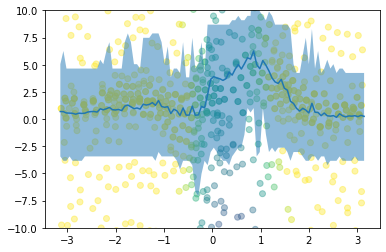

In [96]:

all_measures = measure_fold_whole_sheet(sheet, window=40)

fig, ax = plt.subplots()
ax.scatter(
    sheet.vert_df['latitude'],
    sheet.vert_df['z'],
    c=sheet.vert_df['depth'].clip(upper=10),
    alpha=0.4
)
ax.fill_between(
    all_measures.index,
    all_measures.z_sl,
    all_measures.z_sr,
    alpha=0.5
)
ax.plot(all_measures.index, all_measures.z_depth)

ax.set_ylim(-10, 10)

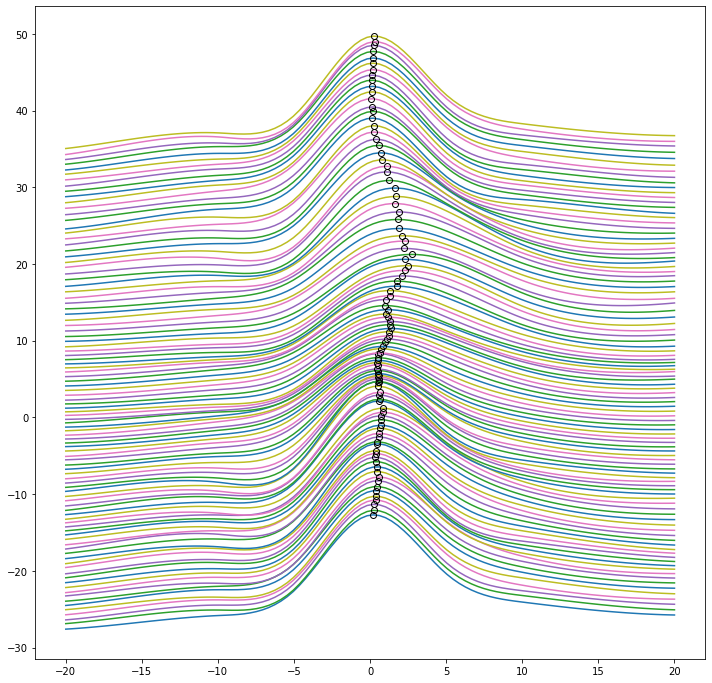

In [89]:
fig, ax = plt.subplots()
zz = np.linspace(-20, 20, 100)
for t, data in all_measures.i_depth.iteritems():
    ax.plot(zz, data+t*10)
    ax.plot(all_measures.loc[t, "z_depth"], all_measures.loc[t, "depth"] + t*10, 'o', mfc="none", mec='k')
fig.set_size_inches(12, 12)

In [261]:
from tyssue.draw import sheet_view

In [262]:
lats = all_measures.index.to_numpy()

sheet.face_df['latitude'] = np.arctan2(
        sheet.face_df['y'],
        sheet.face_df['x'],
    )
sheet.face_df['depth'] = np.sqrt(
    sheet.face_df['y']**2
    + sheet.face_df['x']**2
)

sheet.face_df['depth'] = sheet.face_df['depth'].max() - sheet.face_df['depth']





In [263]:
lat_bin = pd.cut(sheet.face_df['latitude'], bins=lats, labels=False)

In [265]:
lat_bin

0       74
1       76
2       76
3       69
4       77
        ..
1620    20
1621    45
1622    61
1623    33
1624     2
Name: latitude, Length: 1625, dtype: int64

In [278]:
face_z_slopes = all_measures.iloc[lat_bin.to_numpy()]["z_depth"]
face_z_slopes.index = lat_bin.index

In [282]:
width = 3
is_infold = (
    (sheet.face_df['z'] > face_z_slopes - width)
    & (sheet.face_df['z'] < face_z_slopes + width))

In [283]:
ipv.clear()
fig, mesh = sheet_view(
    sheet,
    mode="3D",
    face={
        "visible": True,
        "color": is_infold.astype(float),
    }
)

fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [258]:
lats

array([-3.14159265e+00, -3.07876080e+00, -3.01592895e+00, -2.95309709e+00,
       -2.89026524e+00, -2.82743339e+00, -2.76460154e+00, -2.70176968e+00,
       -2.63893783e+00, -2.57610598e+00, -2.51327412e+00, -2.45044227e+00,
       -2.38761042e+00, -2.32477856e+00, -2.26194671e+00, -2.19911486e+00,
       -2.13628300e+00, -2.07345115e+00, -2.01061930e+00, -1.94778745e+00,
       -1.88495559e+00, -1.82212374e+00, -1.75929189e+00, -1.69646003e+00,
       -1.63362818e+00, -1.57079633e+00, -1.50796447e+00, -1.44513262e+00,
       -1.38230077e+00, -1.31946891e+00, -1.25663706e+00, -1.19380521e+00,
       -1.13097336e+00, -1.06814150e+00, -1.00530965e+00, -9.42477796e-01,
       -8.79645943e-01, -8.16814090e-01, -7.53982237e-01, -6.91150384e-01,
       -6.28318531e-01, -5.65486678e-01, -5.02654825e-01, -4.39822972e-01,
       -3.76991118e-01, -3.14159265e-01, -2.51327412e-01, -1.88495559e-01,
       -1.25663706e-01, -6.28318531e-02,  4.44089210e-16,  6.28318531e-02,
        1.25663706e-01,  

In [234]:
all_measures.index

Float64Index([               -3.14,  -3.0765656565656565,  -3.0131313131313133,
               -2.9496969696969697,  -2.8862626262626265,   -2.822828282828283,
               -2.7593939393939397,   -2.695959595959596,  -2.6325252525252525,
               -2.5690909090909093,  -2.5056565656565657,   -2.442222222222222,
                -2.378787878787879,  -2.3153535353535353,   -2.251919191919192,
               -2.1884848484848485,  -2.1250505050505053,  -2.0616161616161617,
               -1.9981818181818183,  -1.9347474747474747,  -1.8713131313131313,
               -1.8078787878787879,  -1.7444444444444445,   -1.681010101010101,
               -1.6175757575757577,   -1.554141414141414,  -1.4907070707070706,
               -1.4272727272727272,  -1.3638383838383838,  -1.3004040404040405,
               -1.2369696969696968,  -1.1735353535353534,    -1.11010101010101,
               -1.0466666666666664,  -0.9832323232323232,  -0.9197979797979796,
               -0.8563636363636364,  -0.

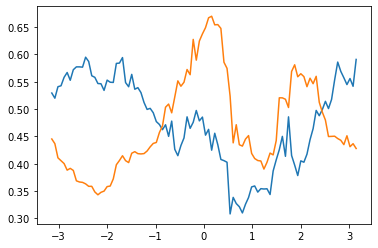

In [231]:
fig, ax = plt.subplots()
ax.plot(all_measures.index, all_measures.slope_left)
ax.plot(all_measures.index, all_measures.slope_right)



In [225]:
def find_max_depth_time(history):

    with pd.HDFStore(history.hf5file, "r") as file:
        v_pos = file.select("vert", columns=["time", "x", "y", "z"]).reset_index()
    center = v_pos[np.abs(v_pos['z']) < 25]
    sq_dpth = center.x**2 + center.y**2
    time = v_pos.loc[sq_dpth.idxmin()]['time']
    return time

In [216]:
history = HistoryHdf5.from_archive(
    '/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20191210-homogenous_Vp_Kp_P0_A0/0.0001_V_10.0_k_4_P0A0_0/out.hf5'
    )

history.datasets["vert"]["time"].unique()

array([0])

In [208]:
history.time_stamps

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149.])